In [ ]:
%cd /content/drive/MyDrive/detectron

/content/drive/MyDrive/detectron


In [ ]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

     |████████████████████████████████| 274 kB 9.9 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=c40cbebd59b9eafe6bf61419c8e16a3fa54e088398087062f18f87bf1fe1787b
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
torch:  1.10 ; cuda:  cu111
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html
     |████████████████████████████████| 7.0 MB 1.8 MB/s 
     |████████████████████████████████| 49 kB 3.8 MB/s 
     |████████████████████████████████| 74 kB 3.7 MB/s 
     |████████████████████████████████| 145 kB 71.3 MB/s 
     |████████████████████████████████| 130 kB 91.0 MB/s 
     |████████████████████████████████| 843 kB 72.3 MB/s 
     |███████████████████████████████

In [ ]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

num_gpu = 1
bs = (num_gpu * 2)

cfg = get_cfg()
cfg.merge_from_file("/content/drive/MyDrive/detectron/detectron2/configs/COCO-Detection/retinanet_R_101_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("sia_train",) # 위에서 정의한 train dataset 변수
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 1
cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/retinanet_R_101_FPN_3x/190397697/model_final_971ab9.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 1 # 한번 배치할때 사용할 이미지
cfg.SOLVER.BASE_LR = 0.02 * bs / 16
cfg.SOLVER.MAX_ITER = 1000 # epoch대신 iteration으로 학습기간을 정함
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 21  # 21 classes
cfg.MODEL.RETINANET.NUM_CLASSES = 21  # Retinanet용 class 개수 지정


Loading config /content/drive/MyDrive/detectron/detectron2/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


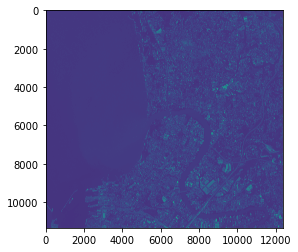

In [ ]:
import gdal
import matplotlib.pyplot as plt
dataset = gdal.Open('/content/drive/Shareddrives/해커톤/5_big_image/modu_large.tif', gdal.GA_ReadOnly)
# Note GetRasterBand() Takes band no. starting from 1 not 0
band = dataset.GetRasterBand(3)
arr = band.ReadAsArray()
plt.imshow(arr)

In [ ]:
def cvt_raw_range_to(image, max_range=255, min_percent=2, max_percent=98, is_use_gray_range=False, dtype=np.uint8):
    """

    :param image:
    :param max_range:
    :param is_use_gray_range:
    :return:
    """
    minimum_values = 10

    if is_use_gray_range:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        cvt_range = gray.max() - gray.min()
        cvt_range = cvt_range if cvt_range != 0 else 1e-16

    image = image.astype(dtype=np.uint16)
    for ch in range(image.shape[2]):
        band = image[:, :, ch]
        fil_band = band[band > minimum_values]

        if is_use_gray_range:
            min_val = np.percentile(fil_band, 1) if fil_band.any() else 0
        else:
            min_val, max_val = find_min_max(fil_band, min_percent=min_percent, max_percent=max_percent)
            cvt_range = max_val - min_val

        band = (band - min_val) / cvt_range * max_range
        band = np.clip(band, 0, max_range * 2) if is_use_gray_range else np.clip(band, 0, max_range)
        image[:, :, ch] = band

    return image.astype(dtype=dtype)

def find_min_max(band, min_percent=2, max_percent=98):
    def _check_minimum_range(min_val, max_val, min_range=256):
        if max_val - min_val < min_range:
            margin = (min_range - (max_val - min_val)) / 2
            min_val -= margin
            max_val += margin

            if min_val < 0:
                max_val -= min_val
                min_val = 0
            if max_val > 2 ** 16:
                min_val -= 2 ** 16 - max_val
                max_val = 2 ** 16 - 1
        return min_val, max_val

    if band.any():
        min_val = np.percentile(band, min_percent)
        max_val = np.percentile(band, max_percent)
    else:
        min_val, max_val = 0, 255

    return _check_minimum_range(min_val, max_val)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


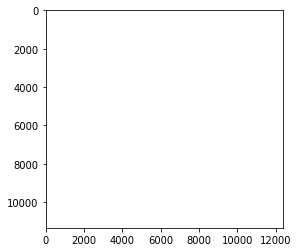

In [ ]:
from osgeo import gdal
import matplotlib.pyplot as plt
import cv2
import numpy as np

dataset = gdal.Open('/content/drive/Shareddrives/해커톤/5_big_image/modu_large.tif', gdal.GA_ReadOnly)

band1 = dataset.GetRasterBand(1)
band2 = dataset.GetRasterBand(2)
band3 = dataset.GetRasterBand(3)
arr1 = band1.ReadAsArray()
arr2 = band2.ReadAsArray()
arr3 = band3.ReadAsArray()

img = cv2.merge((arr1, arr2, arr3))

# uint16 -> uint8 [scale transpose to 0~255]
img_8 = cv2.convertScaleAbs(img, alpha=(255.0/16383.0))

plt.imshow(img)


In [ ]:
img_8_c = cvt_raw_range_to(img)

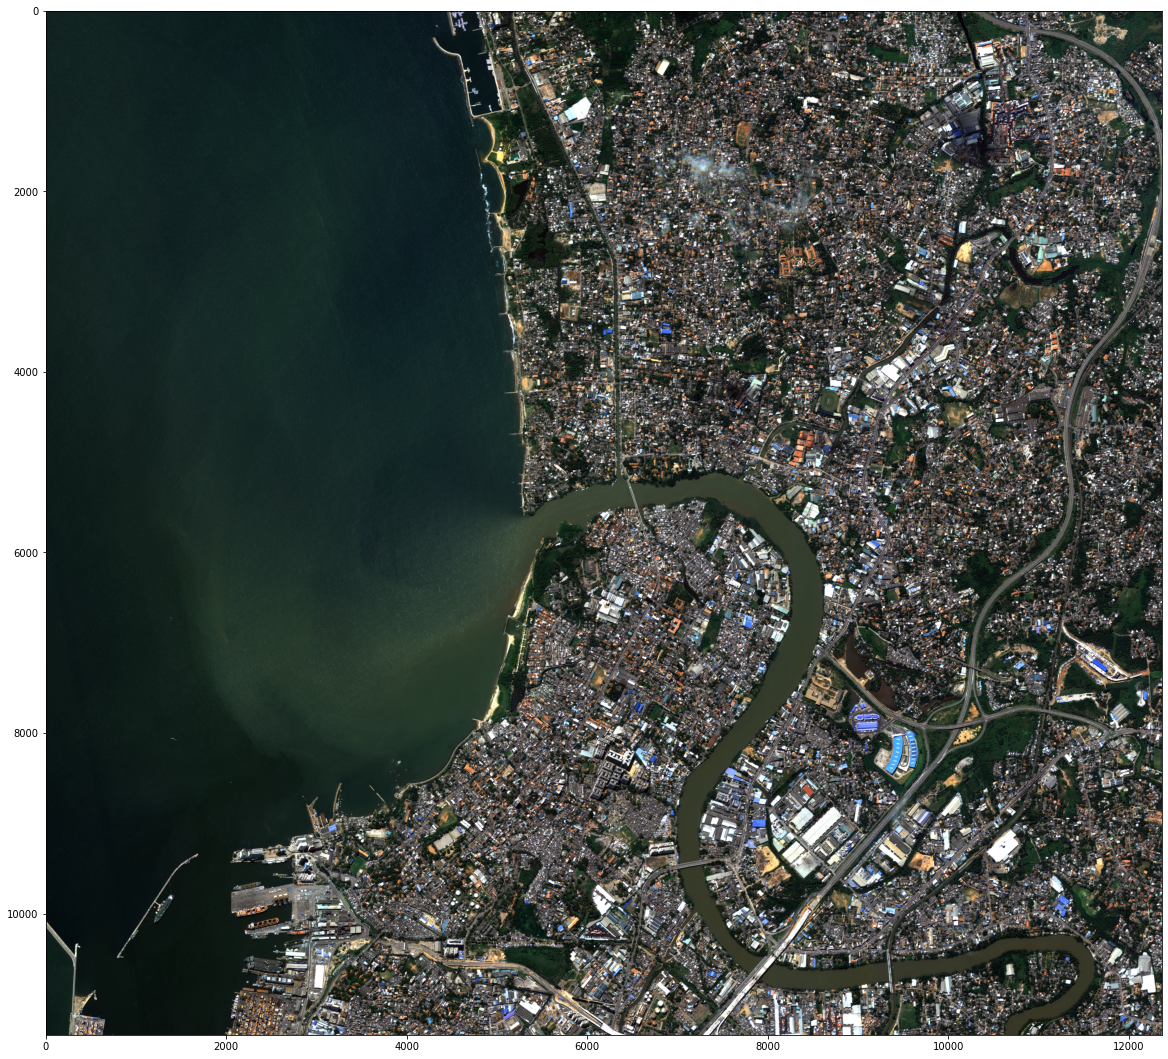

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(img_8_c)

In [ ]:
img_8_c

array([[[ 15,  30,  29],
        [ 21,  42,  48],
        [ 17,  34,  33],
        ...,
        [ 32,  45,  30],
        [ 36,  54,  42],
        [ 42,  65,  54]],

       [[ 16,  32,  30],
        [ 20,  39,  41],
        [ 19,  36,  35],
        ...,
        [ 22,  31,  15],
        [ 29,  45,  34],
        [ 39,  62,  53]],

       [[ 15,  27,  22],
        [ 19,  36,  35],
        [ 20,  37,  36],
        ...,
        [ 18,  28,  16],
        [ 23,  39,  29],
        [ 32,  52,  41]],

       ...,

       [[ 10,  26,  23],
        [ 10,  26,  23],
        [ 11,  28,  26],
        ...,
        [233, 255, 255],
        [218, 246, 255],
        [188, 205, 210]],

       [[  9,  23,  19],
        [ 11,  27,  24],
        [ 14,  33,  34],
        ...,
        [223, 255, 255],
        [209, 238, 253],
        [195, 217, 232]],

       [[  6,  19,  11],
        [ 10,  25,  20],
        [ 12,  29,  26],
        ...,
        [213, 253, 255],
        [202, 233, 251],
        [196, 222, 243]]

In [ ]:
img_8

array([[[ 20,  38,  43],
        [ 22,  41,  47],
        [ 21,  38,  44],
        ...,
        [ 25,  42,  43],
        [ 27,  44,  46],
        [ 29,  47,  49]],

       [[ 21,  38,  44],
        [ 22,  40,  46],
        [ 21,  39,  45],
        ...,
        [ 22,  38,  41],
        [ 25,  42,  44],
        [ 28,  47,  48]],

       [[ 20,  37,  42],
        [ 22,  39,  45],
        [ 22,  39,  45],
        ...,
        [ 21,  37,  41],
        [ 23,  40,  43],
        [ 26,  44,  46]],

       ...,

       [[ 19,  36,  42],
        [ 19,  36,  42],
        [ 19,  37,  43],
        ...,
        [ 88, 105,  93],
        [ 83,  99,  89],
        [ 74,  88,  80]],

       [[ 18,  35,  41],
        [ 19,  37,  42],
        [ 20,  38,  44],
        ...,
        [ 85, 103,  93],
        [ 80,  97,  89],
        [ 76,  91,  84]],

       [[ 18,  34,  40],
        [ 19,  36,  42],
        [ 19,  37,  43],
        ...,
        [ 81, 101,  93],
        [ 78,  95,  88],
        [ 76,  92,  87]]

In [ ]:
scale = '-scale min_val max_val'
options_list = [
                '-ot Byte',
                '-of PNG',
                scale
]
options_string = " ".join(options_list)

gdal.Translate('/content/drive/Shareddrives/해커톤/5_big_image/modu_large_final.png',
               '/content/drive/Shareddrives/해커톤/5_big_image/modu_large.tif',
               options=options_string)


<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f461c483b70> >

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


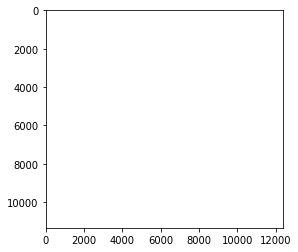

In [ ]:
plt.imshow(img)

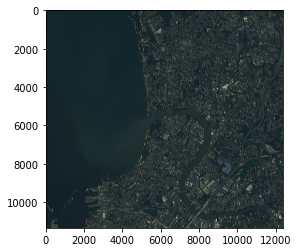

In [ ]:
from osgeo import gdal
import matplotlib.pyplot as plt
import cv2
import numpy as np

dataset = gdal.Open('/content/drive/Shareddrives/해커톤/5_big_image/modu_large.tif', gdal.GA_ReadOnly)

band1 = dataset.GetRasterBand(1)
band2 = dataset.GetRasterBand(2)
band3 = dataset.GetRasterBand(3)
arr1 = band1.ReadAsArray()
arr2 = band2.ReadAsArray()
arr3 = band3.ReadAsArray()

img = cv2.merge((arr1, arr2, arr3))

# uint16 -> uint8 [scale transpose to 0~255]
img_8 = cv2.convertScaleAbs(img, alpha=(255.0/16383.0))

plt.imshow(img_8)


In [ ]:
img_8.shape

(11344, 12362, 3)

In [ ]:
def cvt_raw_range_to(image, max_range=255, min_percent=2, max_percent=98, is_use_gray_range=False, dtype=np.uint8):
    """

    :param image:
    :param max_range:
    :param is_use_gray_range:
    :return:
    """
    minimum_values = 10

    if is_use_gray_range:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        cvt_range = gray.max() - gray.min()
        cvt_range = cvt_range if cvt_range != 0 else 1e-16

    image = image.astype(dtype=np.uint16)
    for ch in range(image.shape[2]):
        band = image[:, :, ch]
        fil_band = band[band > minimum_values]

        if is_use_gray_range:
            min_val = np.percentile(fil_band, 1) if fil_band.any() else 0
        else:
            min_val, max_val = find_min_max(fil_band, min_percent=min_percent, max_percent=max_percent)
            cvt_range = max_val - min_val

        band = (band - min_val) / cvt_range * max_range
        band = np.clip(band, 0, max_range * 2) if is_use_gray_range else np.clip(band, 0, max_range)
        image[:, :, ch] = band

    return image.astype(dtype=dtype)

def find_min_max(band, min_percent=2, max_percent=98):
    def _check_minimum_range(min_val, max_val, min_range=256):
        if max_val - min_val < min_range:
            margin = (min_range - (max_val - min_val)) / 2
            min_val -= margin
            max_val += margin

            if min_val < 0:
                max_val -= min_val
                min_val = 0
            if max_val > 2 ** 16:
                min_val -= 2 ** 16 - max_val
                max_val = 2 ** 16 - 1
        return min_val, max_val

    if band.any():
        min_val = np.percentile(band, min_percent)
        max_val = np.percentile(band, max_percent)
    else:
        min_val, max_val = 0, 255

    return _check_minimum_range(min_val, max_val)

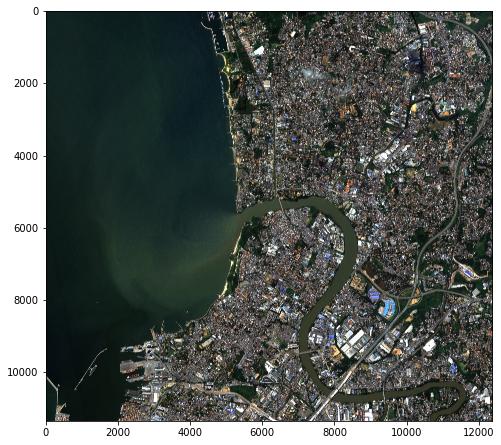

In [ ]:
img_8_c = cvt_raw_range_to(img)
plt.figure(figsize=(8,8))
plt.imshow(img_8_c)

In [ ]:
img_8_c.shape

(11344, 12362, 3)

In [ ]:
R, G, B = cv2.split(img_8)
output1_R = cv2.equalizeHist(R)
output1_G = cv2.equalizeHist(G)
output1_B = cv2.equalizeHist(B)
img_8_m = cv2.merge((output1_R, output1_G, output1_B))

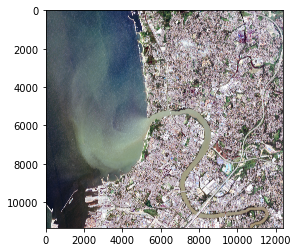

In [ ]:
plt.imshow(img_8_m)

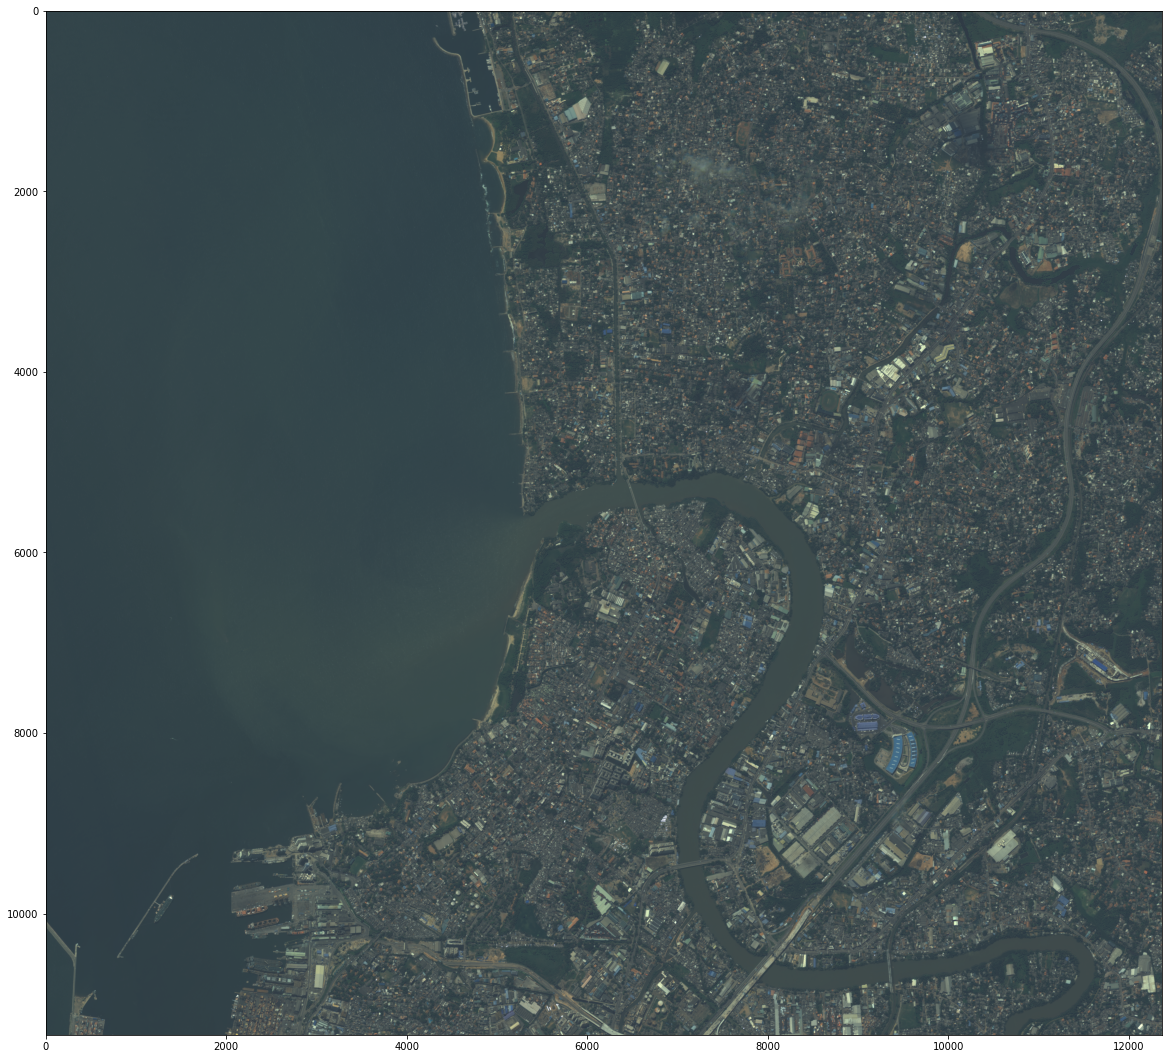

In [ ]:
val = 30
array = np.full(img_8.shape, (val,val,val), dtype=np.uint8)

add = cv2.add(img_8, array)

plt.figure(figsize=(20,20))
plt.imshow(add)

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, 'model_final_250000.pth')
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 # set the testing threshold for this model
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
cfg.TEST.DETECTIONS_PER_IMAGE = 300
cfg.DATASETS.TEST = ('a', )
predictor = DefaultPredictor(cfg)

In [ ]:
def CROPnPREDICT(image, w, h, csv_name):
  s_h = 80 # image.shape[0] % h
  s_w = 74 # image.shape[1] % w

  for i in range(11):
    for j in range(12):
      cropped_image = image[s_h:s_h+h, s_w:s_w+w]
      predicted_image = predictor(cropped_image)
      make_CSV(predicted_image, i, j, csv_name)
      v = Visualizer(cropped_image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.0) # scale값을 조절해 메모리 사용량을 줄일 수 있다.
      v = v.draw_instance_predictions(predicted_image['instances'].to('cpu'))
      cv2.imwrite(f'/content/drive/MyDrive/Crop/{i}_{j}.png', v.get_image()[:, :, ::-1])
      s_w += w
    s_w = image.shape[1] % w
    s_h += h
  return predicted_image

def make_CSV(predicted_image,i,j, csv_name):
  idex_csv = 1
  objs_info_images = []
  objs_info_images.append([])

  # for image in images:
  # image 가져오고 output 계산하기
  object_num = predicted_image['instances'].get_fields()['scores'].shape[0]

  for k in range(object_num):
    obj_info = []

    image_name = f'{i}_{j}.png'
    obj_info.append(image_name)

    obj_info.append(predicted_image['instances'].get_fields()['pred_classes'].cpu().numpy()[k]+1)
    obj_info.append(predicted_image['instances'].get_fields()['scores'].cpu().numpy()[k])

    objs_info_images.append(obj_info)
    print("[ image : %s / %d 번째 객체정보 입력완료 /  csv idex = %d ] "%(image_name, k, idex_csv))
    idex_csv += 1
  with open(csv_name, 'a', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(objs_info_images)

def MERGE(PATH):
  for i in range(11):
      if i==0:
          for j in range(12):
              if j==0:
                  concat_img = cv2.imread(f'/content/drive/MyDrive/Crop/0_0.png')
              else:
                  temp = cv2.imread(f'/content/drive/MyDrive/Crop/0_{j}.png')
                  concat_img = cv2.hconcat([concat_img,temp])
      else:
          for j in range(12):
              if j==0:
                  h_img = cv2.imread(f'/content/drive/MyDrive/Crop/{i}_0.png')
              else:
                  temp = cv2.imread(f'/content/drive/MyDrive/Crop/{i}_{j}.png')
                  h_img = cv2.hconcat([h_img,temp])

          concat_img = cv2.vconcat([concat_img,h_img])
  return concat_img

In [ ]:
import csv
csv_name = './big_image_brighter.csv'
with open(csv_name, 'w', newline='') as f:
  writer = csv.writer(f)

In [ ]:
from detectron2.utils.visualizer import ColorMode
w, h = 1024, 1024

a = CROPnPREDICT(img_8_m, 1024, 1024, csv_name)
merged_image = MERGE('/content/drive/MyDrive/Crop')

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[ image : 0_10.png / 0 번째 객체정보 입력완료 /  csv idex = 1 ] 
[ image : 0_10.png / 1 번째 객체정보 입력완료 /  csv idex = 2 ] 
[ image : 0_11.png / 0 번째 객체정보 입력완료 /  csv idex = 1 ] 
[ image : 0_11.png / 1 번째 객체정보 입력완료 /  csv idex = 2 ] 
[ image : 0_11.png / 2 번째 객체정보 입력완료 /  csv idex = 3 ] 
[ image : 0_11.png / 3 번째 객체정보 입력완료 /  csv idex = 4 ] 
[ image : 1_9.png / 0 번째 객체정보 입력완료 /  csv idex = 1 ] 
[ image : 1_10.png / 0 번째 객체정보 입력완료 /  csv idex = 1 ] 
[ image : 2_4.png / 0 번째 객체정보 입력완료 /  csv idex = 1 ] 
[ image : 2_4.png / 1 번째 객체정보 입력완료 /  csv idex = 2 ] 
[ image : 2_4.png / 2 번째 객체정보 입력완료 /  csv idex = 3 ] 
[ image : 2_4.png / 3 번째 객체정보 입력완료 /  csv idex = 4 ] 
[ image : 2_4.png / 4 번째 객체정보 입력완료 /  csv idex = 5 ] 
[ image : 2_7.png / 0 번째 객체정보 입력완료 /  csv idex = 1 ] 
[ image : 2_10.png / 0 번째 객체정보 입력완료 /  csv idex = 1 ] 
[ image : 3_0.png / 0 번째 객체정보 입력완료 /  csv idex = 1 ] 
[ image : 3_0.png / 1 번째 객체정보 입력완료 /  csv idex = 2 ] 
[ image : 3_0.png / 2 번째 객체정보 입력완료 /  csv idex = 3 ] 
[ image : 3_1.png / 

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

data = pd.read_csv('/content/drive/MyDrive/detectron/big_image_brighter.csv')

df = pd.DataFrame(data)
# df['Image Name'].replace('', np.nan, inplace=True)
df = df.dropna(axis=0)
df

0_10.png   5  0.6792928
0   0_10.png   5   0.573920
1   0_11.png   5   0.845546
2   0_11.png   5   0.837288
3   0_11.png   5   0.810936
4   0_11.png   5   0.691113
..       ...  ..        ...
82  10_5.png   5   0.563962
83  10_6.png   6   0.545770
84  10_7.png  12   0.763394
85  10_7.png   5   0.708997
86  10_7.png   5   0.512360

[87 rows x 3 columns]

In [ ]:
def cvt_raw_range_to(image, max_range=255, min_percent=2, max_percent=98, is_use_gray_range=False, dtype=np.float32):
    """

    :param image:
    :param max_range:
    :param is_use_gray_range:
    :return:
    """
    minimum_values = 10

    if is_use_gray_range:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        cvt_range = gray.max() - gray.min()
        cvt_range = cvt_range if cvt_range != 0 else 1e-16

    image = image.astype(dtype=np.float32)
    for ch in range(image.shape[2]):
        band = image[:, :, ch]
        fil_band = band[band > minimum_values]

        if is_use_gray_range:
            min_val = np.percentile(fil_band, 1) if fil_band.any() else 0
        else:
            min_val, max_val = find_min_max(fil_band, min_percent=min_percent, max_percent=max_percent)
            cvt_range = max_val - min_val

        band = (band - min_val) / cvt_range * max_range
        band = np.clip(band, 0, max_range * 2) if is_use_gray_range else np.clip(band, 0, max_range)
        image[:, :, ch] = band

    return image.astype(dtype=dtype)

def find_min_max(band, min_percent=2, max_percent=98):
    def _check_minimum_range(min_val, max_val, min_range=256):
        if max_val - min_val < min_range:
            margin = (min_range - (max_val - min_val)) / 2
            min_val -= margin
            max_val += margin

            if min_val < 0:
                max_val -= min_val
                min_val = 0
            if max_val > 2 ** 16:
                min_val -= 2 ** 16 - max_val
                max_val = 2 ** 16 - 1
        return min_val, max_val

    if band.any():
        min_val = np.percentile(band, min_percent)
        max_val = np.percentile(band, max_percent)
    else:
        min_val, max_val = 0, 255

    return _check_minimum_range(min_val, max_val)

In [ ]:
!gdal_translate -of PNG /content/drive/Shareddrives/해커톤/5_big_image/modu_large.tif /content/drive/Shareddrives/해커톤/5_big_image/modu_large_2.png